In [1]:
import pypdfium2 as pdfium
import backoff
import asyncio
import os
import base64
from io import BytesIO
import pprint

from IPython.display import Image, display

from typing import List
from typing_extensions import TypedDict

from openai import OpenAIError
from openai import AsyncOpenAI

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

from typing_extensions import TypedDict
from typing import List

from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_core.runnables import RunnablePassthrough

In [2]:
MODEL = "gpt-4o-2024-08-06"
baseurl = ""
apikey = ""

os.environ["OPENAI_API_BASE"] = baseurl
os.environ["OPENAI_API_KEY"] = apikey

clienta = AsyncOpenAI(api_key=apikey,  base_url=baseurl)

In [3]:
#https://www.pondhouse-data.com/blog/document-extraction-with-gpt4o

@backoff.on_exception(backoff.expo, OpenAIError)
async def parse_page_with_gpt(base64_image: str) -> str:
    messages=[
        {
            "role": "system",
            "content": """
            
            You are an OCR expert.

            1. Extract all content images and ensure that all content from the images is captured.
            2. Translate the result into English.
            3. Return the result in a structured JSON format without any additional explanation.

            """
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Return all content"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                        "detail": "high"
                    },
                },
            ],
        }
    ]
    response = await clienta.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        max_tokens=4096,
    )
    return response.choices[0].message.content or ""

In [4]:
from IPython.display import display, Image, HTML

async def document_analysis(filename: str) -> str:
    """
    Document Understanding

    Args:
        filename: pdf filename str
    """

    pdf = pdfium.PdfDocument(filename)
    images = []
    for i in range(len(pdf)):
        page = pdf[i]
        image = page.render(scale=4).to_pil()
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        img_byte = buffered.getvalue()
        img_base64 = base64.b64encode(img_byte).decode("utf-8")
        images.append(img_base64)

    text_of_pages = await asyncio.gather(*[parse_page_with_gpt(image) for image in images])
    #print(text_of_pages)
    
    results = []

    extracted_texts = [doc for doc in text_of_pages]

    for text in extracted_texts:
        cleaned_content_json = text.strip('```json\n').strip('')
        results.append(cleaned_content_json)
        
    return results

In [5]:
docs_list = await document_analysis("ID.jpg.pdf")
docs_list

['{\n  "receipt": {\n    "no_samb": "MD4246",\n    "customer_name": "M.SUBRIN",\n    "address": "BT.BELANG, MUARADUA",\n    "tariff_group": "3B",\n    "administration_fee": "10,000",\n    "material": "0",\n    "installment": "0",\n    "minimum_cubic": "20 M3",\n    "total_rp_cubic": "234,726",\n    "total_bill": "244,726",\n    "admin": "2,500",\n    "total_payment": "247,226",\n    "total_payment_in_words": "DUA RATUS EMPAT PULUH TUJUH RIBU DUA RATUS DUA PULUH ENAM RUPIAH",\n    "billing_month": "JUNI 2020",\n    "initial_stand": "660",\n    "final_stand": "724",\n    "total_usage": "64 M3",\n    "penalty": "0",\n    "date": "13-07-2020 14:17:21",\n    "officer": "KRTN",\n    "note": "Bukti Pembayaran ini adalah SAH, jika sudah dibubuhi cap PDAM TIRTA SAKA SELABUNG MUARADUA."\n  }\n}']

In [6]:
llm = ChatOpenAI(model="gpt-4o")

In [7]:
rag_prompt = PromptTemplate(
    template="""
    You are an assistant for question-answering tasks. 

    Your answer should be the question from the user and the filename from the user's question in JSON format.
    
    Example:
    {{
        'q': 'what is the total amount?',
        'fn': 'abcd.pdf'
    }}
    
    QUESTION: {question} \n
    Answer:
   
    """,
    input_variables=["question"],
)

rag_prompt_chain = rag_prompt | llm | JsonOutputParser()
QUESTION = """what is the total payment from filename: ID.jpg.pdf?"""
result = rag_prompt_chain.invoke({"question": QUESTION})
print(result)

{'q': 'what is the total payment?', 'fn': 'ID.jpg.pdf'}


In [8]:
rag_chain = (
    {"question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | JsonOutputParser()
)

In [9]:
question = "what is the total payment from ID.pdf?"
response_str = rag_chain.invoke(question)
response_str

{'q': 'what is the total payment?', 'fn': 'ID.pdf'}

In [10]:
filename = response_str.get("fn")
question = response_str.get("q")

print(filename)
print(question)

ID.pdf
what is the total payment?


In [11]:
question = "what is the total payment from ID.jpg.pdf?"

response_str = rag_chain.invoke(question)
filename = response_str.get("fn")
question = response_str.get("q")

QUESTION = question
CONTEXT =  await document_analysis(filename)

rag_prompt = PromptTemplate(
    template="""
    You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know.
    Keep the answer concise.
    Return in JSON

  
    QUESTION: {question} \n
    CONTEXT: {context} \n
    Answer:
  
    """,
    input_variables=["question","context"],
)

rag_prompt_chain = rag_prompt | llm | JsonOutputParser()
result = await rag_prompt_chain.ainvoke({"question": QUESTION, "context":CONTEXT})
print(result)

{'total_payment': '247,226'}


In [12]:
### State
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """
    message : str
    results : List[str] # this will now be the RAG results
    rag_questions : List[str]

In [13]:
async def document_analysis_process(state):
    """perform document analysis"""
    print("---DOCUMENT ANALYSIS---")
    question = state['message']
   
    print("questions: ", question)
    response_str = rag_chain.invoke(question)
    filename = response_str.get("fn")
    question = response_str.get("q")

    QUESTION = question
    CONTEXT =  await document_analysis(filename)
    
    rag_prompt = PromptTemplate(
        template="""
        You are an assistant for question-answering tasks. 
        Use the following pieces of retrieved context to answer the question. 
        If you don't know the answer, just say that you don't know.
        Keep the answer concise.
        Return in JSON

        QUESTION: {question} \n
        CONTEXT: {context} \n
        Answer:

        """,
        input_variables=["question","context"],
    )
    
    rag_prompt_chain = rag_prompt | llm | JsonOutputParser()
    rag_results = await rag_prompt_chain.ainvoke({"question": QUESTION, "context":CONTEXT})

    return {"results": rag_results, "rag_questions": question}

In [14]:
init_state = {"message": "what is the total payment from ID.jpg.pdf?"}  
context_state = await document_analysis_process(init_state) 
context_state

---DOCUMENT ANALYSIS---
questions:  what is the total payment from ID.jpg.pdf?


{'results': {'total_payment': '247,226'},
 'rag_questions': 'what is the total payment?'}

In [15]:
# Define a new graph
workflow = StateGraph(GraphState)

# Define the nodes we will cycle between
workflow.add_node("document_analysis_process", document_analysis_process)  # agent

In [16]:
workflow.set_entry_point("document_analysis_process")

In [17]:
workflow.add_edge("document_analysis_process", END)

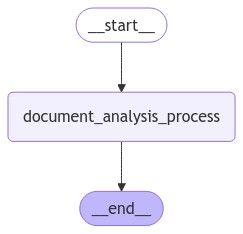

In [18]:
# Compile
graph = workflow.compile()
from IPython.display import Image, display
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
message = "list all content from MM01.jpg.pdf"

In [20]:
inputs = {"message": message}

async for output in graph.astream(inputs, stream_mode="updates"):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---DOCUMENT ANALYSIS---
questions:  list all content from MM01.jpg.pdf
"Output from node 'document_analysis_process':"
'---'
{ 'rag_questions': 'list all content',
  'results': { 'account_number': 'R1230000677',
               'breakdown': { '110 x 50': '5500',
                              '120 x 50': '6000',
                              '125 x 15772': '1971500',
                              '35 x 30': '1050',
                              '50 x 20': '1000',
                              '75 x 25': '1750',
                              '90 x 25': '2250'},
               'charges': { 'electricity': '1,989,050 Ks',
                            'late_fee': '0 Ks',
                            'other_fees': '85,800 Ks',
                            'outstanding_balance': '0 Ks',
                            'service_charge': '5,000 Ks',
                            'total_due': '2,079,850 Ks',
                            'total_payment': '2,079,850 Ks'},
               'consumption': '8426',

In [21]:
message = "what is the total amount, consumption and unit price from MM01.jpg.pdf ?"

inputs = {"message": message}

async for output in graph.astream(inputs, stream_mode="updates"):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---DOCUMENT ANALYSIS---
questions:  what is the total amount, consumption and unit price from MM01.jpg.pdf ?
"Output from node 'document_analysis_process':"
'---'
{ 'rag_questions': 'what is the total amount, consumption and unit price?',
  'results': { 'consumption': '121',
               'total_amount': '2,079,850 Ks',
               'unit_price': '1989050 / 15972'}}
'\n---\n'


In [22]:
message = "what is the total amount, address name of customer and admin fee from ID.jpg.pdf ?"

inputs = {"message": message}

async for output in graph.astream(inputs, stream_mode="updates"):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---DOCUMENT ANALYSIS---
questions:  what is the total amount, address name of customer and admin fee from ID.jpg.pdf ?
"Output from node 'document_analysis_process':"
'---'
{ 'rag_questions': 'what is the total amount, address name of customer and '
                   'admin fee',
  'results': { 'Admin Fee': '2.500',
               'Customer Address': 'BT. BELANG, MUARADUA',
               'Total Amount': '247.226'}}
'\n---\n'
